# Are 2% Mortgages a Thing of the Past?

This project analyses UK two-year fixed mortgage rates in relation to the
Bank of England base rate and CPI inflation to assess whether a return to
~2% mortgages is likely under current monetary conditions.


In [76]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

plt.rcParams["figure.figsize"] = (12, 6)


## Data & Scope

The analysis uses three monthly time-series datasets:
- Two-year fixed mortgage rates
- Bank of England base rate
- CPI inflation (12-month rate)

To ensure consistent overlap across all series, the analysis is restricted
to **2016 onwards** and all data are aligned to **month-end frequency**.


In [77]:
NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = REPO_ROOT / "Data" / "Processed"

df_mort = pd.read_csv(DATA_DIR / "mortgage_clean.csv")
df_bank = pd.read_csv(DATA_DIR / "bank_rate_clean.csv")
df_cpi  = pd.read_csv(DATA_DIR / "cpi_clean.csv")

df_mort.head(), df_bank.head(), df_cpi.head()


(         date  bank_rate  mortgage_rate_2yr  inflation_cpi_12m month_year
 0  2016-01-31        0.5               2.72                0.6   Jan 2016
 1  2016-02-29        0.5               2.70                0.6   Feb 2016
 2  2016-03-31        0.5               2.67                0.8   Mar 2016
 3  2016-04-30        0.5               2.65                0.7   Apr 2016
 4  2016-05-31        0.5               2.62                0.7   May 2016,
          date  bank_rate
 0  2016-01-31        0.5
 1  2016-02-29        0.5
 2  2016-03-31        0.5
 3  2016-04-30        0.5
 4  2016-05-31        0.5,
          date  inflation_cpi_12m
 0  2016-01-01                0.6
 1  2016-02-01                0.6
 2  2016-03-01                0.8
 3  2016-04-01                0.7
 4  2016-05-01                0.7)

## 1. Data Preparation & Monthly Alignment

All datasets are standardised to month-end timestamps prior to merging.
This avoids mismatches caused by differing date granularities and ensures
a consistent time-series structure.


In [78]:
def to_month_end(df, date_col, value_col, new_name):
    out = df[[date_col, value_col]].copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out[date_col] = out[date_col].dt.to_period("M").dt.to_timestamp("M")
    out[value_col] = pd.to_numeric(out[value_col], errors="coerce")
    out = out.groupby(date_col, as_index=False)[value_col].mean()
    out = out.rename(columns={date_col: "date", value_col: new_name})
    return out

mort_m = to_month_end(df_mort, "date", "mortgage_rate_2yr", "mortgage_rate_2yr")
bank_m = to_month_end(df_bank, "date", "bank_rate", "bank_rate")
cpi_m  = to_month_end(df_cpi,  "date", "inflation_cpi_12m", "inflation_cpi_12m")


In [79]:
df_master = (
    mort_m.merge(bank_m, on="date", how="inner")
          .merge(cpi_m,  on="date", how="inner")
          .set_index("date")
          .asfreq("ME")
          .ffill()
)

df_master = df_master[df_master.index >= "2016-01-01"]
df_master.head()


,mortgage_rate_2yr,bank_rate,inflation_cpi_12m
date,,,
2016-01-31,2.72,0.5,0.6
2016-02-29,2.70,0.5,0.6
2016-03-31,2.67,0.5,0.8
2016-04-30,2.65,0.5,0.7
2016-05-31,2.62,0.5,0.7


## 2. Trend Overview

The chart below shows mortgage rates in the context of interest rates and
inflation, highlighting the prolonged low-rate period prior to 2022 and
the sharp adjustment following changes in monetary policy.


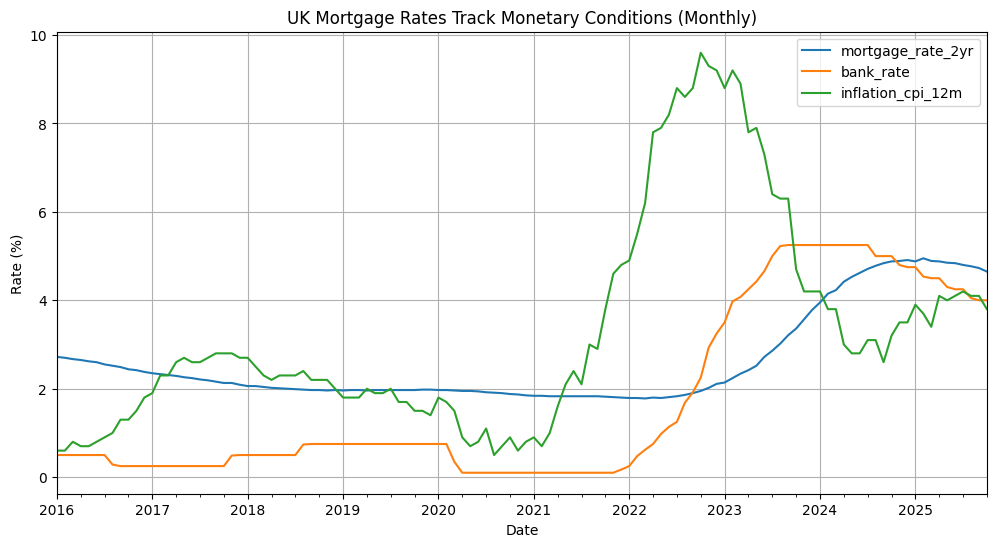

In [80]:
df_master[["mortgage_rate_2yr", "bank_rate", "inflation_cpi_12m"]].plot()
plt.title("UK Mortgage Rates Track Monetary Conditions (Monthly)")
plt.ylabel("Rate (%)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


## 3. Trend Smoothing with Rolling Averages

Rolling averages are used to smooth short-term volatility and highlight
underlying trends in mortgage pricing.


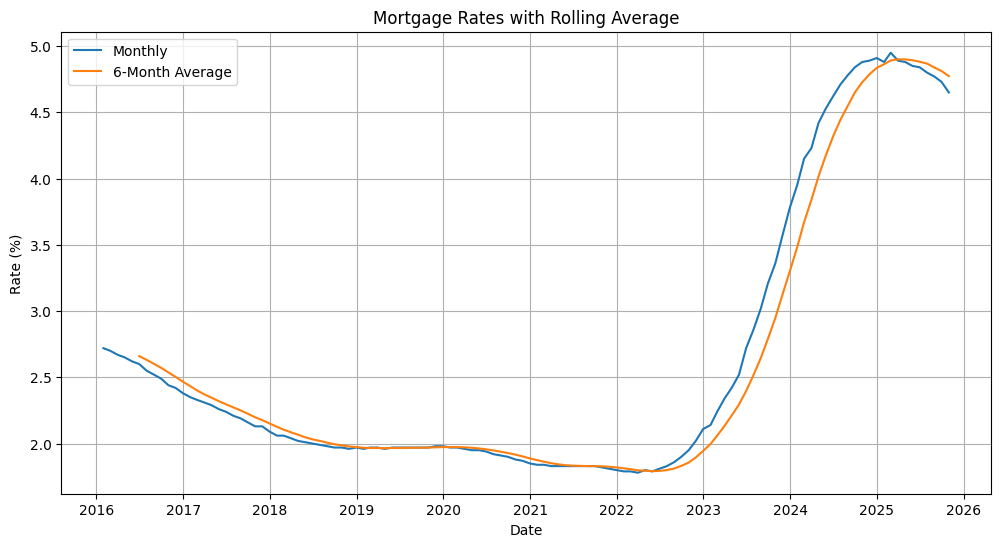

In [81]:
df_master["mortgage_6m_avg"] = df_master["mortgage_rate_2yr"].rolling(6).mean()

plt.plot(df_master.index, df_master["mortgage_rate_2yr"], label="Monthly")
plt.plot(df_master.index, df_master["mortgage_6m_avg"], label="6-Month Average")
plt.legend()
plt.title("Mortgage Rates with Rolling Average")
plt.ylabel("Rate (%)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


## 4. Relationship Evidence: Correlation and Lag Effects

Correlation analysis quantifies the relationship between mortgage rates,
the Bank Rate, and inflation. Lag analysis examines whether mortgage rates
respond to policy changes with a delay.


## 0. Imports & Environment Setup


In [82]:
df_master[["mortgage_rate_2yr", "bank_rate", "inflation_cpi_12m"]].corr()


,mortgage_rate_2yr,bank_rate,inflation_cpi_12m
mortgage_rate_2yr,1.000000,0.826646,0.074947
bank_rate,0.826646,1.000000,0.479148
inflation_cpi_12m,0.074947,0.479148,1.000000


In [83]:
lags = [0, 1, 2, 3]
lag_corr = {
    f"bank_rate_lag_{l}": df_master["mortgage_rate_2yr"].corr(
        df_master["bank_rate"].shift(l)
    )
    for l in lags
}
pd.Series(lag_corr)


bank_rate_lag_0    0.826646
bank_rate_lag_1    0.852458
bank_rate_lag_2    0.876857
bank_rate_lag_3    0.899480
dtype: float64

## 5. Forecasting & Model Evaluation

A baseline ARIMA(1,1,1) model is used to evaluate recent mortgage rate
behaviour. Performance is assessed using a 36-month holdout period.


In [84]:
ts = df_master["mortgage_rate_2yr"].asfreq("ME")

test_size = 36
train, test = ts[:-test_size], ts[-test_size:]

model = ARIMA(train, order=(1,1,1))
fit = model.fit()

forecast = fit.forecast(steps=test_size)

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

mae, rmse


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1.444346090000482, np.float64(1.6442108406011464))

## 6. Interpretation: Are 2% Mortgages a Thing of the Past?

Mortgage rates show a strong relationship with the Bank of England base
rate, typically responding within 1–3 months.

While some easing is possible, the analysis does not support a sustained
return to ~2% two-year fixed mortgages without a fundamental shift in
monetary policy and inflation dynamics.

Rather than being permanently unattainable, 2% mortgages appear to be a
feature of a specific low-rate economic regime rather than a baseline
expectation going forward.


## Limitations & Next Steps

- The ARIMA model is univariate and does not incorporate exogenous drivers.
- Structural breaks reduce long-term forecast reliability.
- Future work could extend this analysis using SARIMAX or scenario analysis.
